In [296]:
import torch, cv2
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [427]:
from pose_drawer.pose_drawer import Pose_Drawer
from pose_detector.model.model import Model

In [428]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
model_base_path = '/home/sam/experiments/Pose_Detector/24_02_beta1_0/models/3.pt'
model = Model()
model.load_state_dict(torch.load(model_base_path))
model = model.eval().cuda()

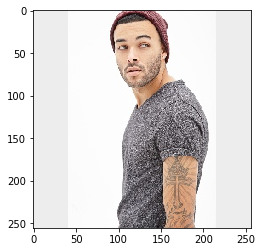

In [665]:
im_path = '/home/sam/data/V_U_Net_DeepFashion/test/01123_2.jpg'
img = cv2.imread(im_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [666]:
img_width, img_height, _ = img.shape
current_max_dim = max(img_width, img_height)
scale_factor = 256 / current_max_dim
resized_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
height, width, _ = resized_img.shape
canvas = np.zeros([256, 256, 3]).astype(int)
canvas[:height, :width, :] = resized_img

In [667]:
canvas_d = canvas.astype('double')
trans = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor = trans(canvas_d).float().cuda()

In [668]:
pred_heat_maps = model(tensor.view(1, 3, 256, 256))
last_hm = pred_heat_maps[2].view(18, 64, 64)
last_hm = last_hm.cpu().detach().numpy()

### Remove error with edge of box showing up too hight

In [669]:
last_hm[:,:2,:] = np.zeros([18,2,64])
last_hm[:,:,:2] = np.zeros([18,64,2])
last_hm[:,-2:, :] = np.zeros([18,2,64])
last_hm[:,:,-2:] = np.zeros([18,64,2])

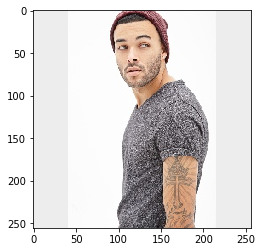

In [670]:
plt.imshow(canvas)

0.31041232

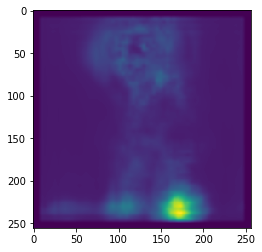

In [671]:
sample_hm = cv2.resize(last_hm[17], None, fx=4, fy=4)
plt.imshow(sample_hm)
np.amax(sample_hm)

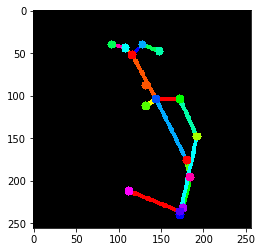

In [674]:
heat_map_tensor = nn.functional.interpolate(pred_heat_maps[2], scale_factor=4).squeeze(0).cpu().detach().numpy()
heat_map_tensor[:,:8,:] = np.zeros([18,8,256])
heat_map_tensor[:,:,:8] = np.zeros([18,256,8])
heat_map_tensor[:,-8:, :] = np.zeros([18,8,256])
heat_map_tensor[:,:,-8:] = np.zeros([18,256,8])
heat_map_list = [heat_map_tensor[i] for i in range(heat_map_tensor.shape[0])]
pose_drawer = Pose_Drawer()
pose_img = pose_drawer.draw_pose_from_heatmaps(heat_map_list)
plt.imshow(pose_img)

In [673]:
from pose_detector.data_modules.dataset import Pose_Detector_Dataset
ds = Pose_Detector_Dataset('/home/sam/data/COCO')
ds = iter(ds)

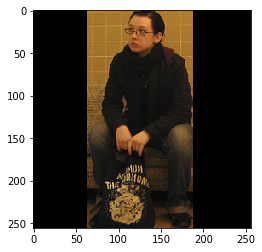

In [205]:
dp = next(ds)
img = ((dp['img'].permute(1, 2, 0) * 0.5) + 0.5)/256
plt.imshow(img)

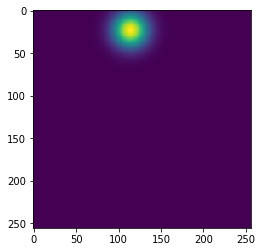

In [217]:
hms = dp['keypoint_heat_maps']
plt.imshow(hms[3])

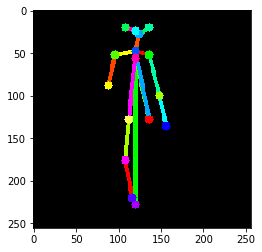

In [55]:
heat_map_list = [heat_map_tensor[i] for i in range(heat_map_tensor.shape[0])]
pose_drawer = Pose_Drawer()
pose_img = pose_drawer.draw_pose_img_from_heatmaps(heat_map_list)
plt.imshow(pose_img)